In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import hmean
from sklearn.metrics import mean_absolute_error

In [2]:
train_data = pd.read_csv('./data/hitter_train_data.csv')
test_data = pd.read_csv('./data/hitter_test_data.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(16625, 20)
(1848, 20)


In [4]:
train_data.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,HR,SO,SB,OPS,ISO,wOBA,WAR,Spd,wRC+,Def,Fld
0,1014396,1982,Robin Yount,MIL,26,156,635,704,210,29,63,14,0.957,0.247,0.415,9.8,6.9,164,16.2,8.0
1,1010978,1984,Cal Ripken,BAL,23,162,641,716,195,27,89,2,0.884,0.206,0.393,9.8,4.0,146,31.9,23.0
2,194,1985,Rickey Henderson,NYY,26,143,547,654,172,24,65,80,0.934,0.201,0.413,9.7,8.5,159,13.8,14.0
3,1001400,1980,George Brett,KCR,27,117,449,515,175,24,22,15,1.118,0.274,0.478,9.1,6.3,198,9.6,9.0
4,1011586,1980,Mike Schmidt,PHI,30,150,548,652,157,48,119,12,1.004,0.338,0.428,9.0,5.6,172,11.9,11.0


In [5]:
train_data = train_data.loc[(train_data['Age'] >= 20).values & (train_data['Age'] <= 40).values, :]
test_data = test_data.loc[(test_data['Age'] >= 21).values & (test_data['Age'] <= 40).values, :]

In [6]:
print(train_data.shape)
print(test_data.shape)

(16535, 20)
(1840, 20)


In [7]:
train_data = train_data.sort_values(by = ['Season', 'Name']).reset_index(drop = True)
test_data = test_data.sort_values(by = ['Season', 'Name']).reset_index(drop = True)

In [8]:
train_data.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,HR,SO,SB,OPS,ISO,wOBA,WAR,Spd,wRC+,Def,Fld
0,1001649,1980,Al Bumbry,BAL,33,160,645,738,205,9,75,44,0.825,0.115,0.371,6.1,7.3,131,2.0,2.0
1,1002689,1980,Al Cowens,- - -,28,142,522,584,140,6,61,6,0.684,0.084,0.310,0.2,3.7,87,-7.1,-1.0
2,1009773,1980,Al Oliver,TEX,33,163,656,709,209,19,47,5,0.838,0.162,0.368,3.4,3.2,130,-14.3,-7.0
3,1014234,1980,Al Woods,TOR,26,109,373,417,112,15,35,4,0.844,0.180,0.375,2.4,3.5,127,-3.3,2.0
4,1000336,1980,Alan Ashby,HOU,28,116,352,394,90,3,40,0,0.665,0.091,0.291,0.8,1.9,86,1.3,-5.0


In [9]:
train_data.groupby('Age')['PA'].sum()

Age
20     16862
21     54542
22    147916
23    266669
24    430414
25    547397
26    620327
27    635644
28    600943
29    565203
30    512634
31    468607
32    391964
33    330481
34    263931
35    199821
36    146885
37    101322
38     63694
39     40903
40     24944
Name: PA, dtype: int64

### Functions

In [10]:
def centralize_data(data, col):
    wm = lambda x: np.average(x, weights = train_data.loc[x.index, 'PA'])
    cols = ['IDfg', 'Season', 'Name', 'Age', 'PA'] + [col]
    df = data.loc[:, cols]

    mean_results = df.groupby(['Season']).agg(weighted_mean = (col, wm))
    mean_results = mean_results.reset_index()
    df = df.merge(mean_results, on = 'Season')
    df[col + '_centralized'] = np.subtract(df[col], df['weighted_mean'])

    return df

In [11]:
def delta_method(data, col):
    cols = ['IDfg', 'Season', 'Name', 'Age', 'PA'] + [col]
    df = data.loc[:, cols]

    df_player_grouped = df.groupby(['IDfg'])
    df['PA_shifted'] = df_player_grouped['PA'].shift(1)
    df['target_diff'] = df_player_grouped[col].diff()
    df['PA_hmean'] = hmean(df[['PA', 'PA_shifted']], axis = 1)
    
    df_age_grouped = df.dropna().groupby(['Age'])
    # total_pa = df_age_grouped['PA'].sum()
    # total_pa = total_pa.reset_index(drop = True)
    wm = lambda x: np.average(x, weights = df.loc[x.index, 'PA_hmean'])
    result = df_age_grouped['target_diff'].agg(wm)
    result = result.reset_index()
    result['delta_method'] = np.cumsum(result['target_diff'])
    # result['delta_method'] = np.cumsum(result['target_diff']) - np.average(np.cumsum(result['target_diff']), weights = total_pa.values)

    return result[['Age', 'delta_method']]

In [12]:
def evaluate(data, col, pred_df):
    data = data.loc[data['Age'] != 20, ]
    df_merged = data.merge(pred_df, on = 'Age', how = 'left')
    mae_result = mean_absolute_error(df_merged[col].values, df_merged['delta_method'].values, sample_weight = data['PA'].values)

    return mae_result

In [13]:
def generate_test_data(train_data, test_data, col):
    test_cols = ['IDfg', 'Season', "Name", 'Age', 'PA', col]

    test_df = test_data.loc[:, test_cols]
    train_player = train_data['IDfg']
    test_player = test_df['IDfg']
    intersection = list(set(train_player) & set(test_player))
    selected_players = test_player.isin(intersection)
    test_df = test_df.loc[selected_players, :]
    
    return test_df

### OPS Aging Curve

In [14]:
ops_data = centralize_data(train_data, 'OPS')
ops_data.head()

,IDfg,Season,Name,Age,PA,OPS,weighted_mean,OPS_centralized
0,1001649,1980,Al Bumbry,33,738,0.825,0.729687,0.095313
1,1002689,1980,Al Cowens,28,584,0.684,0.729687,-0.045687
2,1009773,1980,Al Oliver,33,709,0.838,0.729687,0.108313
3,1014234,1980,Al Woods,26,417,0.844,0.729687,0.114313
4,1000336,1980,Alan Ashby,28,394,0.665,0.729687,-0.064687


In [15]:
ops_result = delta_method(ops_data, 'OPS_centralized')
print(ops_result)

    Age  delta_method
0    21     -0.003441
1    22      0.016195
2    23      0.030131
3    24      0.035392
4    25      0.044110
5    26      0.049277
6    27      0.042419
7    28      0.035527
8    29      0.031375
9    30      0.017756
10   31      0.003579
11   32     -0.016216
12   33     -0.030597
13   34     -0.047620
14   35     -0.063081
15   36     -0.090704
16   37     -0.114602
17   38     -0.154969
18   39     -0.175263
19   40     -0.211701


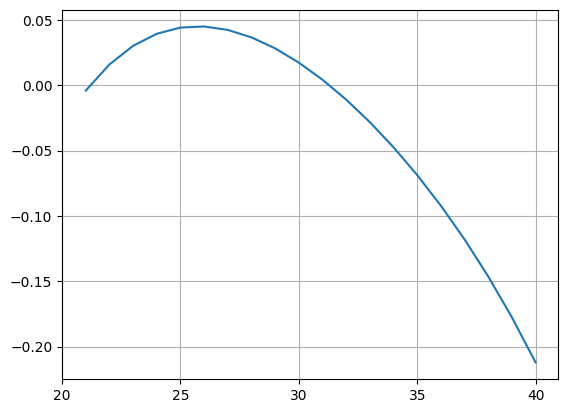

In [16]:
z = np.polyfit(ops_result['Age'].values, ops_result['delta_method'].values, 4)
p = np.poly1d(z)

plt.plot(ops_result['Age'].values, p(ops_result['Age'].values))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()

In [17]:
test_ops_data = centralize_data(test_data, 'OPS')
test_ops_data.shape

(1840, 8)

In [18]:
test_ops_data.head()

,IDfg,Season,Name,Age,PA,OPS,weighted_mean,OPS_centralized
0,9256,2021,A.J. Pollock,33,422,0.892,0.719293,0.172707
1,5297,2021,Aaron Hicks,31,126,0.627,0.719293,-0.092293
2,15640,2021,Aaron Judge,29,633,0.916,0.719293,0.196707
3,5486,2021,Abraham Almonte,32,175,0.730,0.719293,0.010707
4,19844,2021,Abraham Toro,24,375,0.688,0.719293,-0.031293


In [19]:
all_test_data = generate_test_data(ops_data, test_ops_data, 'OPS_centralized')
all_test_data.shape

(1038, 6)

In [20]:
all_test_data.head()

,IDfg,Season,Name,Age,PA,OPS_centralized
0,9256,2021,A.J. Pollock,33,422,0.172707
1,5297,2021,Aaron Hicks,31,126,-0.092293
2,15640,2021,Aaron Judge,29,633,0.196707
3,5486,2021,Abraham Almonte,32,175,0.010707
5,13769,2021,Adalberto Mondesi,25,136,0.003707


In [21]:
evaluate(all_test_data, 'OPS_centralized', ops_result)

0.08761338632599794

### wRC+ Aging Curve

In [22]:
wrc_result = delta_method(train_data, 'wRC+')
print(wrc_result)

    Age  delta_method
0    21     -0.284422
1    22      4.535336
2    23      7.917432
3    24      9.308688
4    25     11.587049
5    26     12.993737
6    27     11.113884
7    28      9.415610
8    29      8.456633
9    30      5.083300
10   31      1.269204
11   32     -3.698734
12   33     -7.414621
13   34    -11.525671
14   35    -15.737671
15   36    -22.926846
16   37    -28.493855
17   38    -39.229728
18   39    -44.966884
19   40    -54.614907


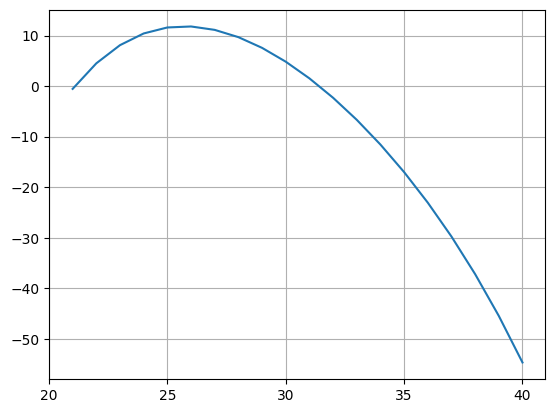

In [23]:
z = np.polyfit(wrc_result['Age'].values, wrc_result['delta_method'].values, 4)
p = np.poly1d(z)

plt.plot(wrc_result['Age'].values, p(wrc_result['Age'].values))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()

In [24]:
all_test_data = generate_test_data(train_data, test_data, 'wRC+')
all_test_data.shape

(1038, 6)

In [25]:
wrc_result['delta_method'] = np.add(wrc_result['delta_method'].values, 100)
evaluate(all_test_data, 'wRC+', wrc_result)

22.47348576717387

According to the aging curves of OPS and wRC+, hitters tend to peak around age 26 and experience a rapid decline after turning 35.